# Glacier mapping with deep learning

In [1]:
import tensorflow as tf
import dataloaders
import h5py
import models.mapping
import losses
import metrics
import utils.deeplearning
import pandas
import numpy as np
import rasterio
import pickle
import subprocess
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils.misc
import os
from tqdm import tqdm

2023-04-13 16:16:36.505950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# configuration variables
batch_size = 4
max_epochs = 1000
learning_rate = 5e-4

patch_size = 384
n_features = 10
n_classes = 2
input_shape = (patch_size, patch_size, n_features)

data_folder = os.path.join("/home", "eouser", "data", "glaciermapping")

### Setting up dataloaders

In [20]:
# open subsets
train = h5py.File(os.path.join(data_folder, "train.hdf5"))
val = h5py.File(os.path.join(data_folder, "val.hdf5"))

In [21]:
# define training dataloader with random sampler and on-fly data augmentation
train_dataloader = dataloaders.DataLoader(
    dataloaders.RandomSampler(train, patch_size), 
    [
        dataloaders.Augmentation([
            dataloaders.transformations.random_vertical_flip(),
            dataloaders.transformations.random_horizontal_flip(),
            dataloaders.transformations.random_rotation(),
            dataloaders.transformations.crop_and_scale(patch_size=patch_size),
        ]),
    ], 
    batch_size,
)

steps_per_epoch = len(train_dataloader)

In [22]:
# define validation dataloader with consecutive (deterministic) sampler 
val_dataloader = dataloaders.DataLoader(
    dataloaders.ConsecutiveSampler(val, patch_size), 
    [], 
    batch_size,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


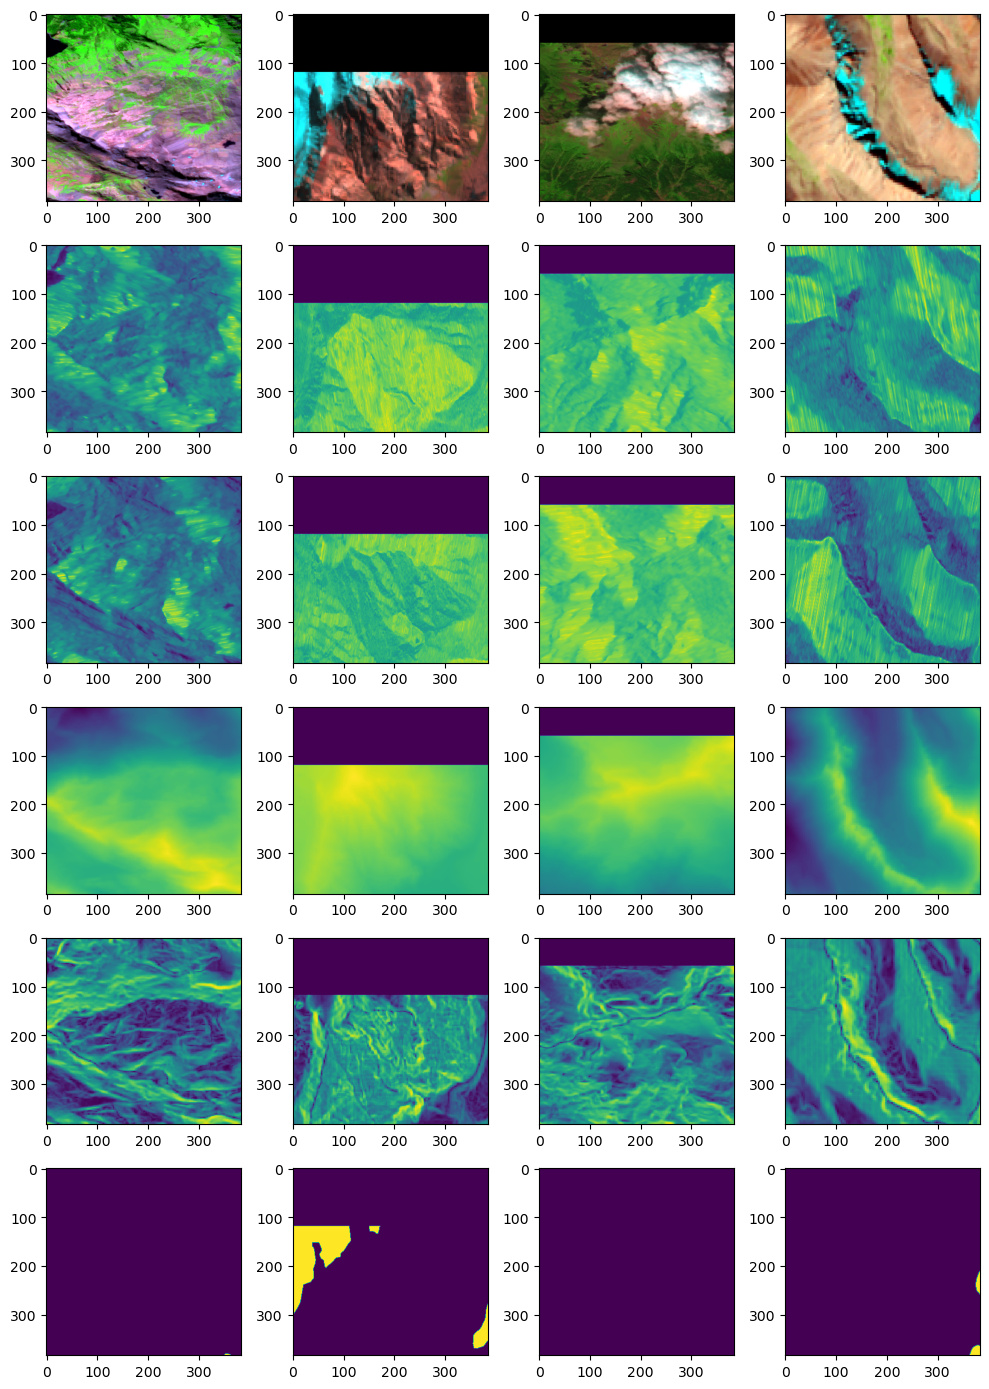

In [23]:
batch_x, batch_y = train_dataloader[42]
_, axs = plt.subplots(nrows=6, ncols=batch_size, figsize=(10, batch_size * 3.5))

for col in range(batch_size):
    axs[0][col].imshow(utils.misc.norm_to_vis(batch_x["features"][col][:, :, [5, 3, 2]]), aspect="auto")
    axs[1][col].imshow(utils.misc.norm_to_vis(batch_x["features"][col][:, :, 6]), aspect="auto")
    axs[2][col].imshow(utils.misc.norm_to_vis(batch_x["features"][col][:, :, 7]), aspect="auto")
    axs[3][col].imshow(utils.misc.norm_to_vis(batch_x["features"][col][:, :, 8]), aspect="auto")
    axs[4][col].imshow(utils.misc.norm_to_vis(batch_x["features"][col][:, :, 9]), aspect="auto")
    axs[5][col].imshow(batch_y[col][:, :, 1], aspect="auto", vmin=0, vmax=1)

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


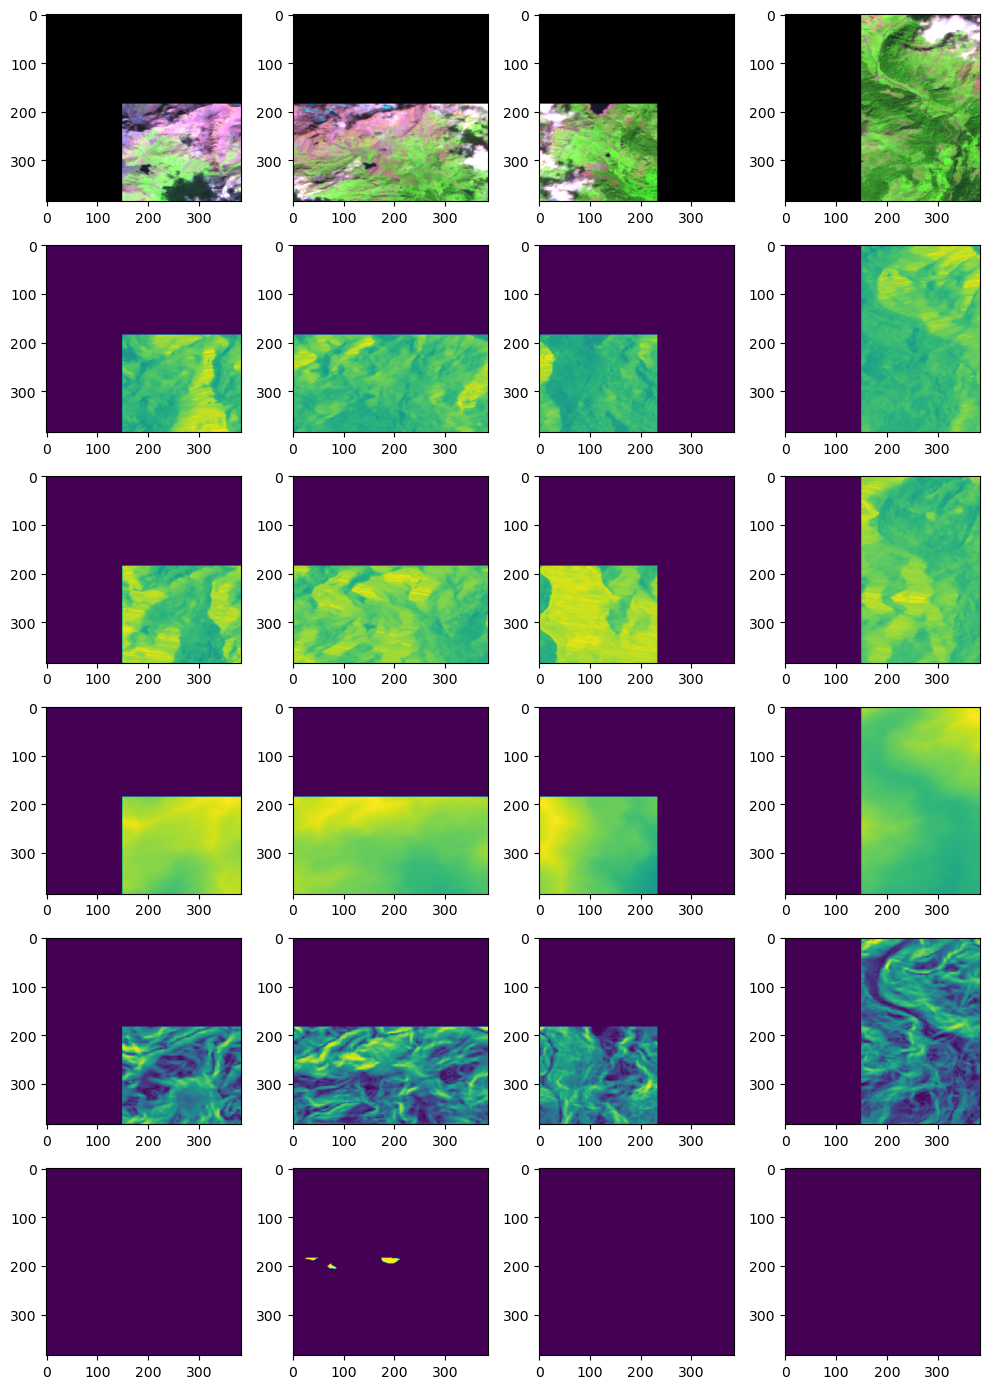

In [24]:
batch_x, batch_y = val_dataloader[42]
_, axs = plt.subplots(nrows=6, ncols=batch_size, figsize=(10, batch_size * 3.5))

for col in range(batch_size):
    axs[0][col].imshow(utils.misc.norm_to_vis(batch_x["features"][col][:, :, [5, 3, 2]]), aspect="auto")
    axs[1][col].imshow(utils.misc.norm_to_vis(batch_x["features"][col][:, :, 6]), aspect="auto")
    axs[2][col].imshow(utils.misc.norm_to_vis(batch_x["features"][col][:, :, 7]), aspect="auto")
    axs[3][col].imshow(utils.misc.norm_to_vis(batch_x["features"][col][:, :, 8]), aspect="auto")
    axs[4][col].imshow(utils.misc.norm_to_vis(batch_x["features"][col][:, :, 9]), aspect="auto")
    axs[5][col].imshow(batch_y[col][:, :, 1], aspect="auto", vmin=0, vmax=1)

plt.tight_layout()
plt.show()

In [25]:
# reset validation daaloader for further use
val_dataloader.sampler.reset()

### Defining model and training

In [9]:
model = models.mapping.DeepLabMini(input_shape, n_classes, name="DeepLabMini")
model.summary()

2023-04-12 21:31:19.192801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-12 21:31:19.539150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-12 21:31:19.540334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-12 21:31:19.541628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Model: "ResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features (InputLayer)          [(None, 384, 384, 1  0           []                               
                                0)]                                                               
                                                                                                  
 ResUNetEncoder (Functional)    [(None, 384, 384, 6  19560064    ['features[0][0]']               
                                4),                                                               
                                 (None, 192, 192, 1                                               
                                28),                                                              
                                 (None, 96, 96, 256                                         

In [10]:
# 'compile' model by providing optimisation algorithm, loss and metrics to track during training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=losses.FocalLoss(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(class_id=1),
        tf.keras.metrics.Recall(class_id=1),
        metrics.IoU(class_id=1),
    ],
)

In [11]:
# define callbacks for saving logs, model weights, early stopping and learning rate schedule
training_callbacks = [
    utils.deeplearning.LRWarmup(
        warmup_steps=steps_per_epoch,
        target=learning_rate,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_iou",
        mode="max",
        factor=0.1,
        patience=10,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_iou",
        mode="max",
        patience=31,
        verbose=1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join("weights", f"{model.name}_weights.h5"),
        monitor=f"val_iou",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    ),
    tf.keras.callbacks.CSVLogger(
        os.path.join("logs", f"{model.name}_log.csv"),
    ),
]

In [ ]:
# finally, train model
model.fit(
    train_dataloader,
    epochs=max_epochs,
    validation_data=val_dataloader,
    callbacks=training_callbacks,
    verbose=1
)

Epoch 1/1000

LRWarmup callback: set learning rate to 0.0


2023-04-12 21:31:51.744117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-12 21:31:51.888723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-12 21:32:02.046083: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55d4c8dc0890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-12 21:32:02.046118: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTXA6000-24C, Compute Capability 8.6
2023-04-12 21:32:02.068700: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-12 21:32:02.230703: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the 

   1/1052 [..............................] - ETA: 11:19:58 - loss: 0.9326 - categorical_accuracy: 0.2470 - precision: 0.0252 - recall: 0.1942 - iou: 0.0206
LRWarmup callback: set learning rate to 4.752851711026616e-07
   2/1052 [..............................] - ETA: 13:21 - loss: 0.9259 - categorical_accuracy: 0.2841 - precision: 0.0294 - recall: 0.2617 - iou: 0.0241   
LRWarmup callback: set learning rate to 9.505703422053232e-07
   3/1052 [..............................] - ETA: 13:24 - loss: 0.8961 - categorical_accuracy: 0.3004 - precision: 0.0665 - recall: 0.4123 - iou: 0.0511
LRWarmup callback: set learning rate to 1.4258555133079848e-06
   4/1052 [..............................] - ETA: 13:24 - loss: 0.9380 - categorical_accuracy: 0.3101 - precision: 0.0608 - recall: 0.3737 - iou: 0.0450
LRWarmup callback: set learning rate to 1.9011406844106463e-06
   5/1052 [..............................] - ETA: 13:24 - loss: 0.9015 - categorical_accuracy: 0.3135 - precision: 0.0546 - recall: 

In [26]:
# close subset
train.close()
val.close()

### Evaluating model

In [3]:
# load model with best weights
model = models.mapping.ResUNet(input_shape, n_classes, name="ResUNet_pretrained")
model.load_weights(os.path.join("weights", f"{model.name}_weights.h5"))

2023-04-13 16:17:00.137833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 16:17:01.950611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 16:17:01.951727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 16:17:01.970264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

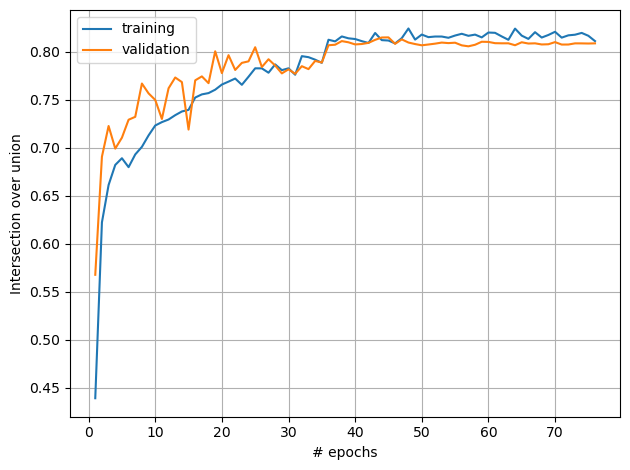

In [4]:
# train/val iou curves
history = pandas.read_csv(os.path.join("logs", f"{model.name}_log.csv"))

plt.plot(history["epoch"] + 1, history["iou"], label="training")
plt.plot(history["epoch"] + 1, history["val_iou"], label="validation")
plt.xlabel("# epochs")
plt.ylabel("Intersection over union")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [5]:
# open test subset
test = h5py.File(os.path.join(data_folder, "test.hdf5"), "r")

In [11]:
# classify test samples
results = {}

for tile in tqdm(test.keys()):
    group = test[tile]

    features = np.array(group["features"])
    outlines = np.array(group["outlines"])
    
    prediction = utils.deeplearning.apply(
        features, model, patch_size=patch_size, batch_size=batch_size, n_outputs=n_classes
    )
    prediction = np.argmax(prediction, axis=-1)
    
    pad_height, pad_width = group.attrs["pad_height"], group.attrs["pad_width"]
    height, width = group.attrs["height"], group.attrs["width"]
    
    features = features[pad_height:pad_height + height, pad_width:pad_width + width, :]
    outlines = outlines[pad_height:pad_height + height, pad_width:pad_width + width, 1]
    prediction = prediction[pad_height:pad_height + height, pad_width:pad_width + width]
    
    results[tile] = {
        "thumbnail": features.reshape((height, width, n_features))[:, :, [5, 3, 2]],
        "outlines": outlines,
        "prediction": prediction
    }

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [03:07<00:00,  2.35s/it]


In [12]:
# close test subset
test.close()

In [13]:
# calculate metrics
tp, fp, fn = 0, 0, 0

for tile, result in tqdm(results.items()):
    groundtruth = result["outlines"]
    prediction = result["prediction"]

    tp_mask = (prediction == 1) & (groundtruth == 1)
    fp_mask = (prediction == 1) & (groundtruth == 0)
    fn_mask = (prediction == 0) & (groundtruth == 1)

    tp += np.sum(tp_mask)
    fp += np.sum(fp_mask)
    fn += np.sum(fn_mask)
        
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
iou = tp / (tp + fp + fn)

print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1-score = {f1}")
print(f"iou = {iou}")

100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 209.52it/s]

precision = 0.9061036955802173
recall = 0.8908350578975434
f1-score = 0.8984045077231074
iou = 0.8155484604118987


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


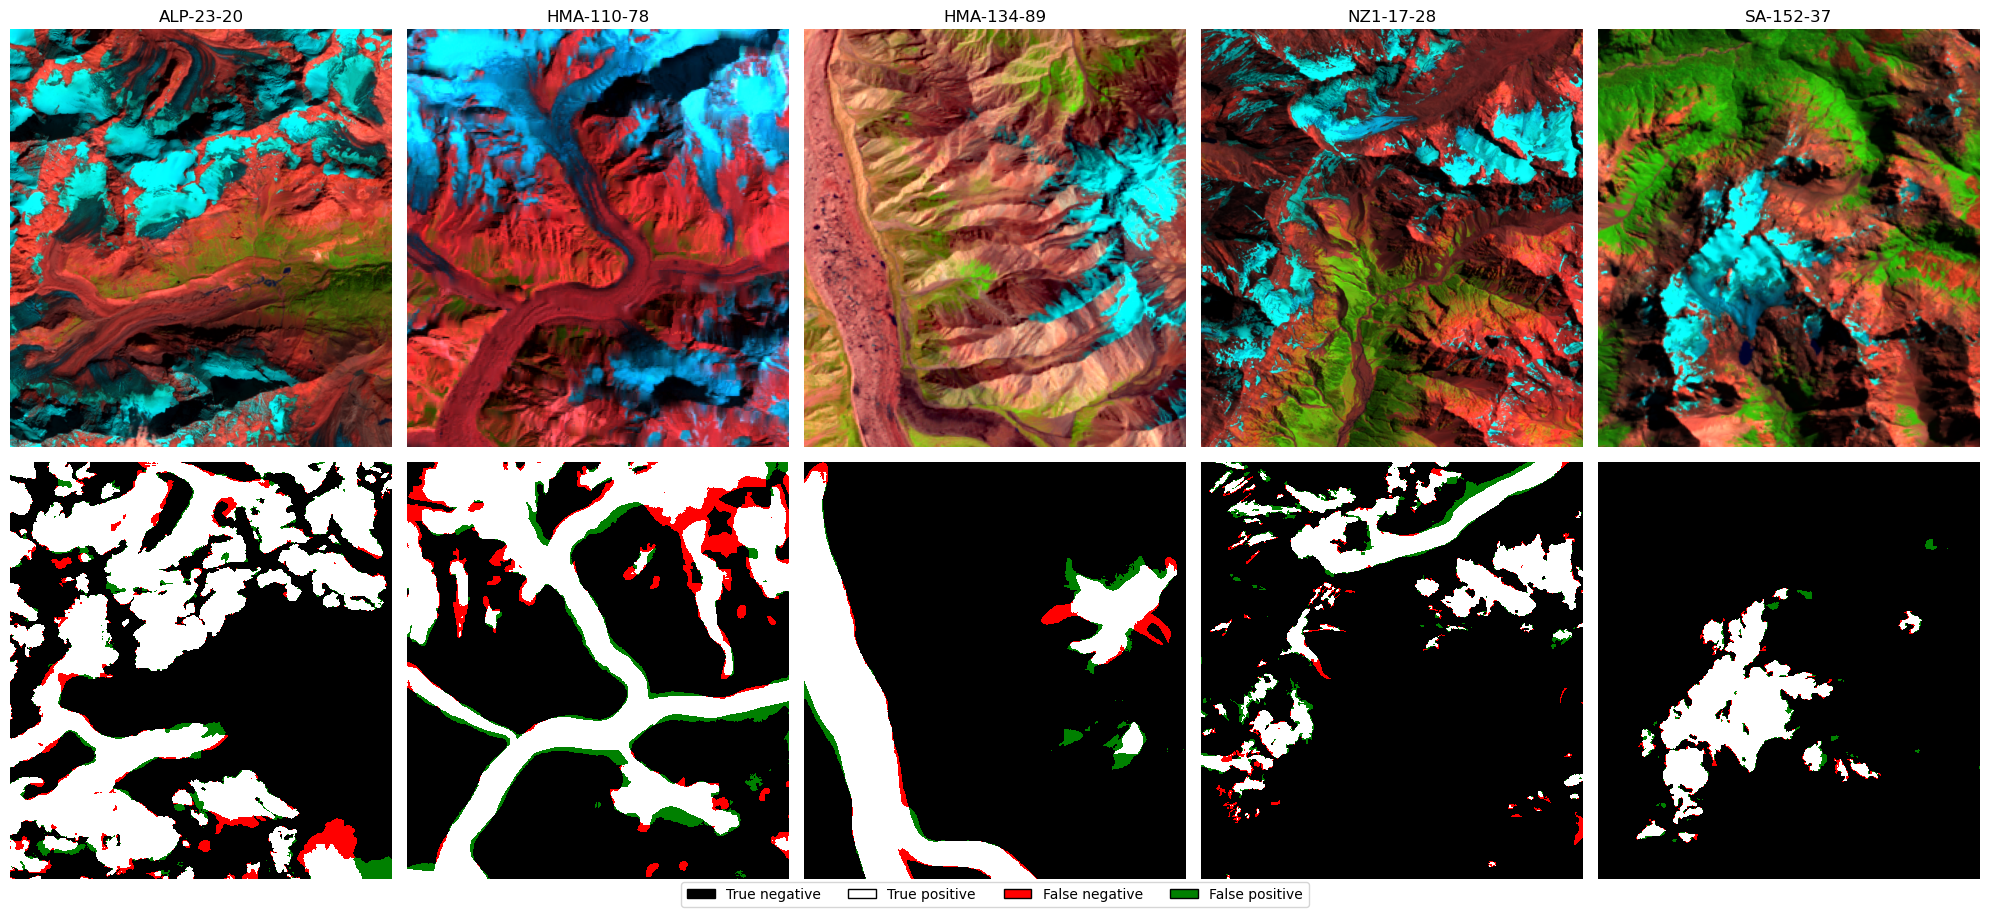

In [14]:
# visualise some tiles
tiles_to_visualise = [
    "ALP-23-20", 
    "HMA-110-78", 
    "HMA-134-89", 
    "NZ1-17-28", 
    "SA-152-37",
]

nrows, ncols = 2, len(tiles_to_visualise)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4.5 * nrows))

for col, tile in enumerate(tiles_to_visualise):
    axes[0][col].set_title(tile)
    
    thumbnail = utils.misc.norm_to_vis(results[tile]["thumbnail"])
    axes[0][col].imshow(thumbnail, aspect="auto")
    
    groundtruth = results[tile]["outlines"]
    prediction = results[tile]["prediction"]
    
    output_colors = ["black", "white", "red", "green"]
    output_cmap = mpl.colors.ListedColormap(output_colors, 4)
    output = np.zeros(prediction.shape)
    output[(prediction == 1) & (groundtruth == 1)] = 1
    output[(prediction == 0) & (groundtruth == 1)] = 2
    output[(prediction == 1) & (groundtruth == 0)] = 3
    axes[1][col].imshow(
        output / 3, vmin=0, vmax=1, aspect="auto", cmap=output_cmap, 
        interpolation="none"
    )

for row in range(nrows):
    for col in range(ncols):
        axes[row][col].axis("off")
    
labels = ["True negative", "True positive", "False negative", "False positive"]
handles = [mpl.patches.Patch(facecolor=_, edgecolor="black") for _ in output_colors]

fig.legend(handles, labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.022))

plt.tight_layout()
plt.show()

### Applying trained model

In [4]:
# load data stack for HMA1
with rasterio.open(os.path.join(data_folder, "raster", "HMA1", "stack.tif")) as src:
    stack = src.read()
    stack = np.moveaxis(stack, 0, -1)
    meta = src.meta.copy()

In [5]:
# normalize features
with open(os.path.join(data_folder, "mins_maxs.pickle"), "rb") as min_max_file:
    mins, maxs = pickle.load(min_max_file)
    
stack = (stack - mins) / (maxs - mins)
stack[np.isnan(stack)] = 0
stack[np.isinf(stack)] = 0

In [6]:
# pad stack to fit patch size
height, width, _ = stack.shape
new_height = (height // patch_size + 1) * patch_size
new_width = (width // patch_size + 1) * patch_size
pad_height = (new_height - height) // 2
pad_width = (new_width - width) // 2

stack_pad = np.zeros((new_height, new_width, n_features))
stack_pad[pad_height:pad_height + height, pad_width:pad_width + width, :] = stack

In [7]:
# apply model
prediction = utils.deeplearning.apply(
    stack_pad, model, patch_size=patch_size, batch_size=batch_size, n_outputs=n_classes
)
prediction = np.argmax(prediction, axis=-1)
prediction = prediction[pad_height:pad_height + height, pad_width:pad_width + width]

2023-04-13 16:20:53.840546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-13 16:20:54.782153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [11]:
# save raster output
meta.update({
    "dtype": np.uint8,
    "count": 1,
    "nodata": 0
})

raster_output_path = os.path.join("outputs", "hma1_prediction.tif")
with rasterio.open(raster_output_path, "w", **meta) as dst:
    dst.write(prediction, 1)

In [12]:
vector_output_path = os.path.join("outputs", "hma1_prediction.shp")
subprocess.run(f"""
    bash -c '
    source ~/anaconda3/bin/activate;
    conda activate geodask;
    python utils/geo/polygonize.py {raster_output_path} {vector_output_path}
    '
""", shell=True)

CompletedProcess(args="\n    bash -c '\n    source ~/anaconda3/bin/activate;\n    conda activate geodask;\n    python utils/geo/polygonize.py outputs/hma1_prediction.tif outputs/hma1_prediction.shp\n    '\n", returncode=0)

<AxesSubplot: >

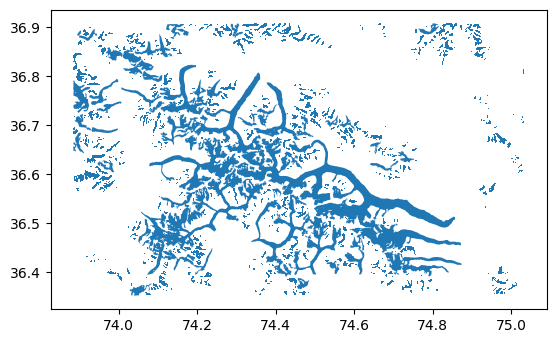

In [13]:
vector_prediction = geopandas.read_file(vector_output_path)
vector_prediction.plot()